# Reading ADV Data with MHKiT

This example presents a simplified workflow for analyzing Acoustic Doppler Velocimetry (ADV) data using MHKiT. MHKiT incorporates the DOLfYN codebase as a module to handle ADV and Acoustic Doppler Current Profiler (ADCP) data.

This particular dataset is an excerpt from a cabled ADV mounted to a Sea Spider tripod, where the ADV was sampling on a duty cycle where 5 minutes of data was recorded every 20 minutes. All of the steps for a non-cabled ADV still apply, excepting the probe-inst rotation step.

A standard ADV data analysis workflow can be segmented into the following steps:

1. **Raw Data Review**: Evaluate the original data by verifying timestamps and assessing the quality of velocity data, specifically looking for any data spikes.

2. **Data Cleaning**: Identify and eliminate any spurious data points. If needed, bad data points can be replaced with interpolated values.

3. **Data Rotation**: Transform the data into the principal flow coordinates, which are the streamwise, cross-stream, and vertical directions.

4. **Data Averaging**: Aggregate the data into bins or ensembles, each of which spans a predefined time length, typically between 5 and 10 minutes.

5. **Statistical Analysis**: Compute turbulence statistics such as turbulence intensity, Turbulent Kinetic Energy (TKE), and Reynolds stresses for the observed flow field.

Start your analysis by importing the necessary tools:

In [1]:
from mhkit import dolfyn
from mhkit.dolfyn.adv import api

## Read Raw Instrument Data

DOLfYN currently only carries support for the Nortek Vector ADV. The example loaded here is a short clip of data from a test deployment to show DOLfYN's capabilities.

Start by reading in the raw datafile downloaded from the instrument. The `dolfyn.read` function reads the raw file and dumps the information into an xarray Dataset, which contains three groups of variables:

1. Velocity, amplitude, and correlation of the Doppler velocimetry
2. Measurements of the instrument's bearing and environment
3. Orientation matrices DOLfYN uses for rotating through coordinate frames.

In [2]:
ds = dolfyn.read("data/dolfyn/vector_cabled_imu01.VEC")

Reading file data/dolfyn/vector_cabled_imu01.VEC ...


There are two ways to see what's in a Dataset. The first is to simply type the dataset's name to see the standard xarray output. To access a particular variable in a dataset, use dict-style (`ds['vel']`) or attribute-style syntax (`ds.vel`). See the [xarray docs](http://xarray.pydata.org/en/stable/getting-started-guide/quick-overview.html) for more details on how to use the xarray format.

In [3]:
# print the dataset
ds

<xarray.Dataset> Size: 25MB
Dimensions:              (time: 216039, beam: 3, dir: 3, x1: 3, x2: 3,
                          earth: 3, inst: 3)
Coordinates:
  * time                 (time) datetime64[ns] 2MB 2025-02-25T10:00:03.587208...
  * beam                 (beam) int32 12B 1 2 3
  * dir                  (dir) <U1 12B 'X' 'Y' 'Z'
  * x1                   (x1) int32 12B 1 2 3
  * x2                   (x2) int32 12B 1 2 3
  * earth                (earth) <U1 12B 'E' 'N' 'U'
  * inst                 (inst) <U1 12B 'X' 'Y' 'Z'
Data variables: (12/17)
    beam2inst_orientmat  (x1, x2) float64 72B 2.575 -1.305 ... 0.3582 0.3455
    batt                 (time) float32 864kB 13.4 13.4 13.4 ... nan nan nan
    c_sound              (time) float32 864kB 1.477e+03 1.477e+03 ... nan nan
    heading              (time) float32 864kB 0.0 0.0 0.0 0.0 ... nan nan nan
    pitch                (time) float32 864kB 0.0 0.0 0.0 0.0 ... nan nan nan
    roll                 (time) float32 864kB 0.0 0.0 0.0 0.0 ... nan nan nan
    ...                   ...
    amp                  (beam, time) uint8 648kB 84 93 104 103 ... 106 106 95
    corr                 (beam, time) uint8 648kB 94 98 98 97 99 ... 95 97 97 92
    accel                (dir, time) float32 3MB 9.53 9.536 ... -1.229 -1.219
    angrt                (dir, time) float32 3MB 0.000111 ... -0.0005012
    orientmat            (earth, inst, time) float32 8MB 0.1533 ... -0.1279
    pressure             (time) float32 864kB 8.865 8.869 8.86 ... 7.073 7.073
Attributes: (12/42)
    inst_make:                   Nortek
    inst_model:                  Vector
    inst_type:                   ADV
    rotate_vars:                 ['vel', 'accel', 'angrt']
    n_beams:                     3
    profile_mode:                continuous
    ...                          ...
    duty_cycle_n_burst:          9600
    duty_cycle_interval:         1200
    duty_cycle_description:      300.0 second bursts collected at 32.0 Hz, wi...
    fs:                          32.0
    coord_sys:                   inst
    has_imu:                     1

A second way provided to look at data is through the *DOLfYN view*. This view has several convenience methods, shortcuts, and functions built-in. It includes an alternate – and somewhat more informative/compact – description of the data object when in interactive mode. This can be accessed using

In [4]:
ds_dolfyn = ds.velds
ds_dolfyn

<ADV data object>:  Nortek Vector
  . 7.37 hours (started: Feb 25, 2025 10:00)
  . inst-frame
  . (216039 pings @ 32.0Hz)
  Variables:
  - time ('time',)
  - vel ('dir', 'time')
  - orientmat ('earth', 'inst', 'time')
  - heading ('time',)
  - pitch ('time',)
  - roll ('time',)
  - temp ('time',)
  - pressure ('time',)
  - amp ('beam', 'time')
  - corr ('beam', 'time')
  - accel ('dir', 'time')
  - angrt ('dir', 'time')
  ... and others (see `<obj>.variables`)

## Set rotation for cabled ADV head
For cable-head ADVs, be sure to record the position and orientation of the ADV head relative to the ADV pressure case ‘inst’ coordinate system. This ADV was set up in the same orientation as the one shown in Figure 1 [here](https://dolfyn.readthedocs.io/en/stable/motion-correction.html); the rotation matrix for this setup is written below. Per the Nortek documentation, in this orientation, the probe "X" direction is the IMU's "-Z" direction.

If utilizing a non-cabled ADV (the standard version), skip this step.

In [5]:
# This is the rotation matrix per Figure 1: https://dolfyn.readthedocs.io/en/stable/motion-correction.html
dolfyn.set_inst2head_rotmat(ds, [[0, 0, -1], [0, -1, 0], [-1, 0, 0]])

## Quality Control

ADV velocity data tends to have spikes due to Doppler noise. There are multiple approaches to removing bad values, including trimming beyond a maximum range, removing values with low acoustic correlation values, and finally another is to "despike" the data is by using the phase-space algorithm by Goring and Nikora (2002). DOLfYN integrates QC functions using a 2-step approach: create a logical mask where True corresponds to a spike detection, and then remove and/or interpolate those values.

In [6]:
# Remove low correlation values and noisy beam measurements
ds.velds.rotate2("beam")
# Start a mask by copying the velocity data-array
mask = ds["vel"].copy() * 0
# Now we'll remove values with correlation < 80% and velocity outside of +/- 0.7 m/s
# We decide this +/- 0.7 m/s threshold by looking at plots of the along-beam velocity
mask = mask + (ds["corr"].values < 80) + (ds["vel"] > 0.7) + (ds["vel"] < -0.7)
# Set the mask to boolean
mask = mask.astype(bool)
# Replace bad datapoints using the ensemble mean over a 5-minute window
ds["vel"] = dolfyn.adv.clean.fill_nan_ensemble_mean(
    ds["vel"], mask, int(ds.fs), window=300
)
print("Percent of data containing spikes: {0:.2f}%".format(100 * mask.mean()))

# How to use the Goring+Nikora method to clean spikes in ADV data:
ds_ex = ds.copy(deep=True)
# Clean the file using the Goring+Nikora method:
mask_ex = api.clean.GN2002(ds.vel, npt=5000)
# Replace bad datapoints via cubic spline interpolation
ds_ex["vel"] = api.clean.clean_fill(ds_ex["vel"], mask, npt=12, method="cubic", maxgap=None)

# If interpolation isn't desired:
ds_nan = ds.copy(deep=True)
ds_nan.coords["mask"] = (("dir", "time"), ~mask_ex)
ds_nan["vel"] = ds_nan["vel"].where(ds_nan["mask"])

Percent of data containing spikes: 0.12%


## Coordinate Rotations

Now that the data has been cleaned, the next step is to rotate the velocity data into true East, North, Up (ENU) coordinates.

ADVs use an internal compass or magnetometer to determine magnetic ENU directions. The `set_declination` function takes the user supplied magnetic declination (which can be looked up online for specific coordinates) and adjusts the orientation matrix saved within the dataset.

Instruments save vector data in the coordinate system specified in the deployment configuration file. To make the data useful, it must be rotated through coordinate systems ("beam"<->"inst"<->"earth"<->"principal"), done through the `rotate2` function. If the "earth" (ENU) coordinate system is specified, DOLfYN will automatically rotate the dataset through the necessary coordinate systems to get there. The `inplace` set as true will alter the input dataset "in place", i.e., it not create a new dataset.

In [7]:
# First set the magnetic declination
dolfyn.set_declination(
    ds, declin=15.3, inplace=True
)  # declination points 15.3 degrees East

# Rotate that data from the instrument to earth frame (ENU):
dolfyn.rotate2(ds, "earth", inplace=True)

Once in the true ENU frame of reference, we can calculate the principal flow direction for the velocity data and rotate it into the principal frame of reference (streamwise, cross-stream, vertical). Principal flow directions are aligned with and orthogonal to the flow streamlines at the measurement location. 

First, the principal flow direction must be calculated through `calc_principal_heading`. As a standard for DOLfYN functions, those that begin with "calc_*" require the velocity data for input. This function is different from others in DOLfYN in that it requires placing the output in an attribute called "principal_heading", as shown below.

Again we use `rotate2` to change coordinate systems.

In [8]:
ds.attrs["principal_heading"] = dolfyn.calc_principal_heading(ds["vel"])
dolfyn.rotate2(ds, "principal", inplace=True)

Once we've done quality control and coordinate rotations (not necessarily in that order), we can plot the velocity vector to see how it looks:

Text(0.5, 1.0, '')

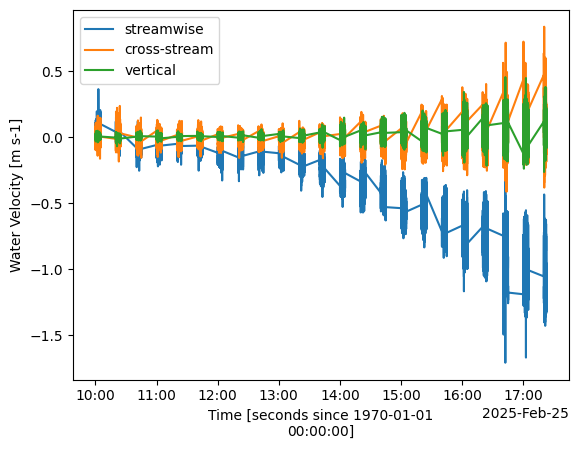

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
ds["vel"][0].plot(label="streamwise")
ds["vel"][1].plot(label="cross-stream")
ds["vel"][2].plot(label="vertical")
plt.legend()
plt.title("")

## Averaging Data
The next step in ADV analysis is to average the velocity data into time bins (ensembles) and calculate turbulence statistics. These averaged values are then used to calculate turbulence statistics. There are two distinct methods for performing this operation, both of which utilize the same variable inputs and produce identical datasets.

1. **Object-Oriented Approach** (standard): Define an 'averaging object', create a dataset binned in time, and calculate basic turbulence statistics. This is accomplished by initiating an object from the ADVBinner class and then feeding that object with our dataset.

2. **Functional Approach** (simple): The same operations can be performed using the functional counterpart of ADVBinner, turbulence_statistics.

Function inputs shown here are the dataset itself: 
 - `n_bin`: the number of elements in each bin; 
 - `fs`: the ADV's sampling frequency in Hz; 
 - `n_fft`: optional, the number of elements per FFT for spectral analysis; 
 - `freq_units`: optional, either in Hz or rad/s, of the calculated spectral frequency vector.

All of the variables in the returned dataset have been bin-averaged, where each average is computed using the number of elements specified in `n_bins`. Additional variables in this dataset include the turbulent kinetic energy (TKE) vector ("ds_binned.tke_vec"), the Reynold's stresses ("ds_binned.stress"), and the power spectral densities ("ds_binned.psd"), calculated for each bin.

In [10]:
# Option 1 (standard)
binner = api.ADVBinner(n_bin=ds.fs * 600, fs=ds.fs, n_fft=ds.fs * 600)
ds_binned = binner.bin_average(ds)

# Option 2 (simple)
# ds_binned = api.calc_turbulence(ds, n_bin=ds.fs*600, fs=ds.fs, n_fft=ds.fs*600, freq_units="Hz")

The benefit to using `ADVBinner` is that one has access to all of the velocity and turbulence analysis functions that DOLfYN contains. If basic analysis will suffice, the `turbulence_statistics` function is the most convienent. Either option can still utilize DOLfYN's shortcuts.

See the [DOLfYN API](https://dolfyn.readthedocs.io/en/latest/apidoc/dolfyn.binners.html) for the full list of functions and shortcuts. A few examples are shown below.

Some things to know:
- All functions operate bin-by-bin.
- Some functions will fail if there are NaN's in the data stream (Notably the PSD functions)
- "Shortcuts", as referred to in DOLfYN, are functions accessible by the xarray accessor `velds`, as shown below. The list of "shortcuts" available through `velds` are listed [here](https://dolfyn.readthedocs.io/en/latest/apidoc/dolfyn.shortcuts.html). Some shortcut variables require the raw dataset, some an averaged dataset.

For instance, 
- `bin_variance` calculates the binned-variance of each variable in the raw dataset, the complementary to `bin_average`. Variables returned by this function contain a "_var" suffix to their name.
- `power_spectral_density` calculates the power spectral density (velocity spectra) of the velocity vector
- `cross_spectral_density` calculates the cross spectral density between each direction of the supplied DataArray. Note that inputs specified in creating the `ADVBinner` object can be overridden or additionally specified for a particular function call.
- `turbulence_intensity` is calculated from the ratio of the standard deviation of the horizontal velocity magnitude (equivalent to the RMS of turbulent velocity fluctuations) to the mean of the horizontal velocity magnitude
- `integral_length_scales` estimates the integral length scale in the streamwise, transverse, and vertical directions from the first crossing of the autocorrelation function
- `turbulent_kinetic_energy` calculates the TKE (Reynolds normal stress) components
- `reynolds_stress` calculates the Reynolds shear stress components
- `dissipation_rate_LT83` uses the Lumley and Terray 1983 algorithm to estimate the TKE dissipation rate from the isoropic turbulence cascade seen in the spectral. This requires the frequency range of the cascade as input.



In [11]:
# Calculate the variance of each variable in the dataset and add to the averaged dataset
ds_binned = binner.bin_variance(ds, out_ds=ds_binned)

# Calculate the power spectral density
ds_binned["auto_spectra"] = binner.power_spectral_density(ds["vel"], freq_units="Hz")

# Calculate the cross power spectral densities
ds_binned["cross_spectra"] = binner.cross_spectral_density(
    ds["vel"], freq_units="Hz", n_fft_coh=ds.fs * 200
)

# Water speed and direction
ds_binned["U_mag"] = ds_binned.velds.U_mag
ds_binned["U_dir"] = ds_binned.velds.U_dir

# Calculate the Doppler noise level from the white noise floor of the auto-spectra
ds_binned["noise"] = binner.doppler_noise_level(ds_binned["auto_spectra"], pct_fN=0.8)

# Calculate the turbulence intensity and subtract the average horizontal velocity noise level
ds_binned["TI"] = binner.turbulence_intensity(
    ds.velds.U_mag, noise=ds_binned["noise"][:2].mean("S")
)

# Calculate the auto-covariance to find the integral length scales
autocov = binner.autocovariance(ds["vel"])
ds_binned["length_scale"] = binner.integral_length_scales(autocov, ds_binned["U_mag"])

# Calculate the TKE components and Reynolds shear stresses
ds_binned['tke_vec'] = binner.turbulent_kinetic_energy(ds["vel"])
ds_binned['stress_vec'] = binner.reynolds_stress(ds["vel"])

# Calculate dissipation rate from isotropic turbulence cascade
ds_binned["dissipation_rate"] = binner.dissipation_rate_LT83(
    ds_binned["auto_spectra"], ds_binned["U_mag"], noise=ds_binned["noise"], freq_range=[0.8, 2]
)


## Saving and Loading DOLfYN datasets
Datasets can be saved and reloaded using the `save` and `load` functions. Xarray is saved natively in netCDF format, hence the ".nc" extension.

Note: DOLfYN datasets cannot be saved using xarray's native `ds.to_netcdf`; however, DOLfYN datasets can be opened using `xarray.open_dataset`.

In [12]:
# Uncomment these lines to save and load to your current working directory
# dolfyn.save(ds, 'your_data.nc')
# ds_saved = dolfyn.load('your_data.nc')

## Visualization
Plotting can be performed using matplotlib. As an example, the mean spectrum in the streamwise direction is plotted here. This spectrum shows the mean energy density in the flow at a particular flow frequency.

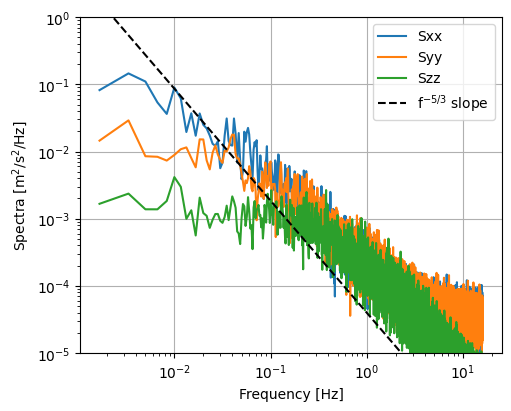

In [13]:
fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
for spec in ds_binned["S"]:
    ax.loglog(
        ds_binned["freq"],
        ds_binned["auto_spectra"].sel(S=spec).mean(dim="time"),
        label=spec.values,
    )
ax.plot(
    ds_binned["freq"], 4e-5 * ds_binned["freq"] ** (-5 / 3), "k--", label="f$^{-5/3}$ slope"
)
ax.set(ylim=(1e-5, 1), xlabel="Frequency [Hz]", ylabel="Spectra [m$^2$/s$^2$/Hz]")
ax.grid()
ax.legend()

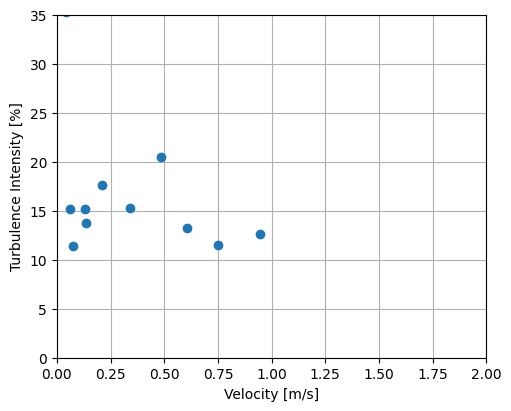

In [14]:
# Turbulence intensity
fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
ax.scatter(
    abs(ds_binned["U_mag"]),
    ds_binned["TI"] * 100,
)
ax.set(xlabel="Velocity [m/s]", ylabel="Turbulence Intensity [%]", xlim=[0, 2], ylim=[0, 35])
ax.set_axisbelow(True)  # set grid below data
ax.grid()

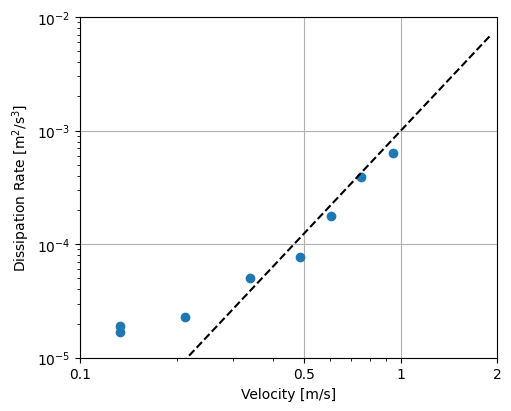

In [15]:
# TKE Dissipation rate
import numpy as np

x_ticks = [0.1, 0.5, 1, 2]
y_ticks = [0.00001, 0.0001, 0.001, 0.01]
y_labels = [r"10$^{-5}$", r"10$^{-4}$", r"10$^{-3}$", r"10$^{-2}$"]
U = np.arange(0, 2, 0.1)

fig, ax = plt.subplots(
    figsize=(5, 4),
    subplot_kw={"xscale": "log", "yscale": "log"},
    constrained_layout=True,
)
ax.scatter(
    abs(ds_binned["U_mag"]),
    ds_binned["dissipation_rate"][0]
)
ax.plot(U, U**3 * 10 ** (-3), "--", color="black", label="U$^3$ slope")

# Set axis labels
ax.set(
    xlabel="Velocity [m/s]",
    ylabel="Dissipation Rate [m$^2$/s$^3$]",
    ylim=(y_ticks[0], y_ticks[-1]),
    yticks=y_ticks,
    yticklabels=y_labels,
    xlim=(x_ticks[0], x_ticks[-1]),
    xticks=x_ticks,
    xticklabels=x_ticks,
)
ax.set_axisbelow(True)  # set grid below data
ax.grid()

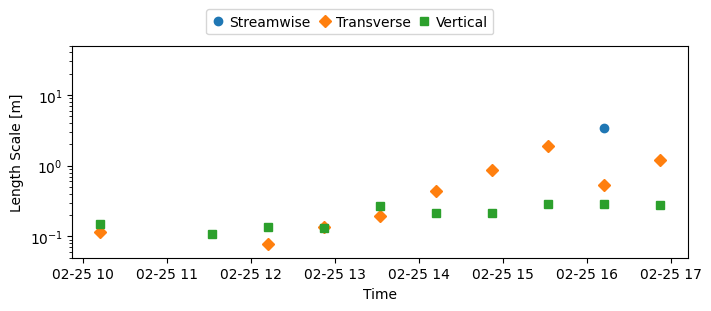

In [16]:
# Length scales
fig, ax = plt.subplots(
    figsize=(7, 3), subplot_kw={"yscale": "log"}, constrained_layout=True
)
ax.plot(ds_binned["time"].values, ds_binned["length_scale"][0], "o")
ax.plot(ds_binned["time"].values, ds_binned["length_scale"][1], "D")
ax.plot(ds_binned["time"].values, ds_binned["length_scale"][2], "s")

ax.set(xlabel="Time", ylabel="Length Scale [m]", ylim=(0.05, 50))
ax.legend(
    ("Streamwise", "Transverse", "Vertical"),
    bbox_to_anchor=(-0.05, 1.02, 1, 0.102),
    loc="lower center",
    ncol=3,
    handlelength=1,
    columnspacing=0.5,
    handletextpad=0.3,
)

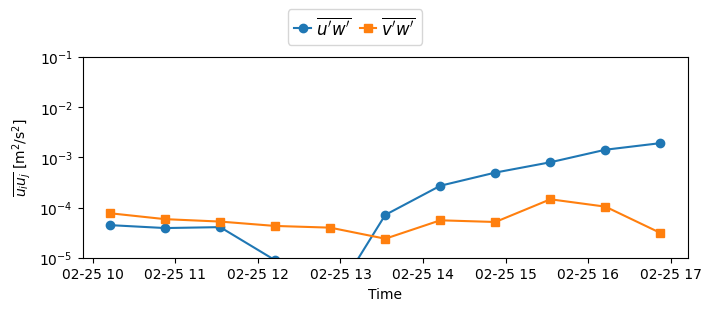

In [17]:
# Reynolds stresses
fig, ax = plt.subplots(figsize=(7, 3), constrained_layout=True)
# u'w' bar
ax.plot(
    ds_binned["time"].values,
    np.log10(abs(ds_binned["stress_vec"][1])),
    "o-"
)
# v'w' bar
ax.plot(
    ds_binned["time"].values,
    np.log10(abs(ds_binned["stress_vec"][2])),
    "s-"
)

y_labels = [r"10$^{-5}$", r"10$^{-4}$", r"10$^{-3}$", r"10$^{-2}$", r"10$^{-1}$"]
ax.set(
    xlabel="Time",
    ylabel=r"$\overline{u_iu_j}$ " + "[m$^2$/s$^2$]",
    ylim=(-5, -1),
    yticks=[-5, -4, -3, -2, -1],
    yticklabels=y_labels,
)
ax.legend(
    (r"$\overline{u'w'}$", r"$\overline{v'w'}$"),
    # (r"$\overline{u'v'}$", r"$\overline{u'w'}$", r"$\overline{v'w'}$"),
    bbox_to_anchor=(-0.05, 1.02, 1, 0.102),
    loc="lower center",
    ncol=3,
    handlelength=1,
    columnspacing=0.5,
    handletextpad=0.3,
    fontsize=12,
)